In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes as load_mesh, load_obj

from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# For colab -> function that returns the required local
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Get util script
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

- Set to run on the gpu (indexed 0 if more than one) or cpu

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [3]:
# object and texture files gotten from https://free3d.com/3d-model/hobbyking-bixler-sky-surfer-89447.html
# remember to check the .mtl file and ensure that it points to the correct location for the texture file
!mkdir -p data/plane_mesh

In [ ]:
!unzip -d /content/data/plane_mesh \*.zip  && rm *.zip

In [3]:
path = ['/content/data/plane_mesh/modelFinals/bixler.obj']
plane_mesh = load_mesh(path, device=device)

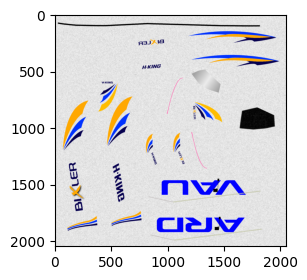

In [8]:
plt.figure(figsize=(3,3))
texture_image=plane_mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())

In [5]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 4

# Get a batch of viewing angles, a visualisation here: https://www.photopills.com/articles/understanding-azimuth-and-elevation
distance = 50.0
elevation_ang = torch.linspace(10, 90, num_views)
azimuth_ang = torch.linspace(10, 180, num_views)

img_size = 256
blur_radius = 0.0
faces_per_pixel = 2

In [6]:
lights = PointLights(device=device, location=[[2.0, 0.0, 0.0]])

materials = Materials(
    device=device,
    # specular_color=[[0.0, 1.0, 0.0]], : RGB
    shininess=10.0
)

# Create a perspective camera
R, T = look_at_view_transform(dist=distance, elev=elevation_ang, azim=azimuth_ang)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...],
                                  T=T[None, 1, ...])

raster_settings = RasterizationSettings(
    image_size=img_size,
    blur_radius=blur_radius,
    faces_per_pixel=faces_per_pixel,
    bin_size=0
    # max_faces_per_bin

)

# Create a Phong renderer
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights,
        materials=materials
    )
)

# Create a batch of meshes
meshes = plane_mesh.extend(num_views)

# Renderg the plane mesh
plane_images = renderer(meshes, cameras=cameras, lights=lights)

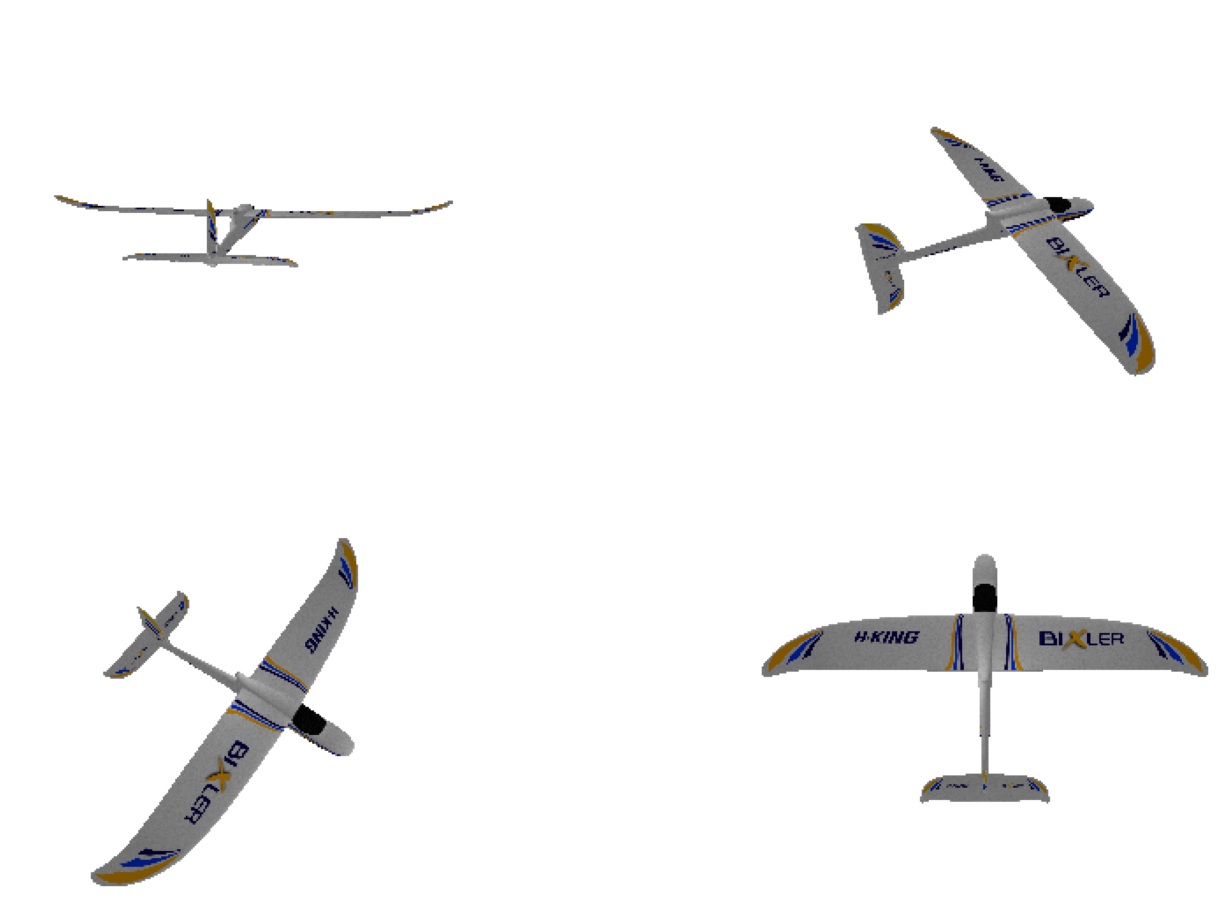

In [7]:
# Show images
image_grid(plane_images.cpu().numpy(), rows=2, cols=2, rgb=True)
plt.show()